<a href="https://colab.research.google.com/github/sbogde/pandamonium/blob/main/dmi_04_covid_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import time
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# For clustering and scaling
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# For mapping
import folium
from folium.plugins import MarkerCluster

# For plotting the elbow method
%matplotlib inline

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

In [ ]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive, data_table
    drive.mount('/content/drive', force_remount=True)
    file_path = '/content/drive/My Drive/Colab Notebooks/data-mining/data/01-02-2023.csv'
    data_table.enable_dataframe_formatter()
else:
    file_path = './data/01-02-2023.csv'  # Local path

Mounted at /content/drive


In [ ]:
# Load the dataset (adjust the file path as needed)
df = pd.read_csv(file_path)

In [ ]:
# Display basic information about the dataset
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (4016, 14)


,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incident_Rate,Case_Fatality_Ratio
0,NaN,NaN,NaN,Afghanistan,2023-01-03 04:21:07,33.93911,67.709953,207627,7849,NaN,NaN,Afghanistan,533.356919,3.780337
1,NaN,NaN,NaN,Albania,2023-01-03 04:21:07,41.15330,20.168300,333812,3595,NaN,NaN,Albania,11599.555216,1.076953
2,NaN,NaN,NaN,Algeria,2023-01-03 04:21:07,28.03390,1.659600,271229,6881,NaN,NaN,Algeria,618.523486,2.536971
3,NaN,NaN,NaN,Andorra,2023-01-03 04:21:07,42.50630,1.521800,47751,165,NaN,NaN,Andorra,61801.591924,0.345543
4,NaN,NaN,NaN,Angola,2023-01-03 04:21:07,-11.20270,17.873900,105095,1930,NaN,NaN,Angola,319.765542,1.836434


In [10]:
# Select relevant columns (for example: Country, Confirmed, Deaths, Recovered, Active, Latitude, Longitude)
# Adjust the column names based on your CSV file structure
# df = df[['Country', 'Confirmed', 'Deaths', 'Recovered', 'Active', 'Latitude', 'Longitude']]
columns_to_use = ["Country_Region", "Province_State", "Lat", "Long_", "Confirmed", "Deaths", "Recovered", "Active"]
df = df[columns_to_use]

# Fill missing numerical values with 0
df.fillna(0, inplace=True)

# Drop rows missing latitude or longitude since these are needed for mapping
df.fillna({'Confirmed': 0, 'Deaths': 0, 'Recovered': 0, 'Active': 0}, inplace=True)
df.dropna(subset=['Lat', 'Long_'], inplace=True)

print("Preprocessed dataset shape:", df.shape)
df.head()

Preprocessed dataset shape: (4016, 8)


,Country_Region,Province_State,Lat,Long_,Confirmed,Deaths,Recovered,Active
0,Afghanistan,0,33.93911,67.709953,207627,7849,0.0,0.0
1,Albania,0,41.15330,20.168300,333812,3595,0.0,0.0
2,Algeria,0,28.03390,1.659600,271229,6881,0.0,0.0
3,Andorra,0,42.50630,1.521800,47751,165,0.0,0.0
4,Angola,0,-11.20270,17.873900,105095,1930,0.0,0.0


In [15]:
# Choose numerical columns to scale (e.g. Confirmed, Deaths, Recovered, Active)
features = ['Confirmed', 'Deaths', 'Recovered', 'Active']

# Initialise the StandardScaler
scaler = StandardScaler()

# Fit and transform the features to standardise them (mean=0, std=1)
df_scaled = scaler.fit_transform(df[features])

# Convert the scaled array back to a DataFrame for convenience
df_scaled = pd.DataFrame(df_scaled, columns=features)
df_scaled['Country'] = df['Country_Region']
df_scaled['Latitude'] = df['Lat']
df_scaled['Longitude'] = df['Long_']

# df_scaled = scaler.fit_transform(df[["Confirmed", "Deaths", "Recovered", "Active"]])


print("Scaled DataFrame shape:", df_scaled.shape)
df_scaled.head()

Scaled DataFrame shape: (4016, 7)


,Confirmed,Deaths,Recovered,Active,Country,Latitude,Longitude
0,0.041081,0.710185,0.0,0.0,Afghanistan,33.93911,67.709953
1,0.161672,0.221466,0.0,0.0,Albania,41.15330,20.168300
2,0.101863,0.598977,0.0,0.0,Algeria,28.03390,1.659600
3,-0.111709,-0.172589,0.0,0.0,Andorra,42.50630,1.521800
4,-0.056907,0.030183,0.0,0.0,Angola,-11.20270,17.873900


In [16]:
# Define the number of clusters, for example 5 (this value can be adjusted)
k = 5

# Initialise K-Means with k clusters, using k-means++ initialisation for better performance
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
df_scaled['Cluster'] = kmeans.fit_predict(df_scaled[features])

print("Cluster assignments:")
print(df_scaled['Cluster'].value_counts())


Cluster assignments:
Cluster
0    3920
3      84
1       8
2       2
4       2
Name: count, dtype: int64


In [17]:
# Create a base map centred approximately on the world
world_map = folium.Map(location=[20, 0], zoom_start=2)

# Optionally use a MarkerCluster to group close markers together
marker_cluster = MarkerCluster().add_to(world_map)

# Define a list of colours for clusters (adjust or extend as necessary)
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred']

# Add markers for each region
for idx, row in df_scaled.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"Country: {row['Country']}\nCluster: {row['Cluster']}\nConfirmed: {row['Confirmed']}",
        icon=folium.Icon(color=colors[row['Cluster'] % len(colors)])
    ).add_to(marker_cluster)

# Save the map to an HTML file
world_map.save('covid19_clusters_map.html')
print("Map has been saved as covid19_clusters_map.html")


Map has been saved as covid19_clusters_map.html


In [18]:
# Group data by cluster and compute mean values for numerical features
cluster_summary = df_scaled.groupby('Cluster')[features].mean()
print("Cluster Summary:")
print(cluster_summary)

Cluster Summary:
         Confirmed     Deaths  Recovered  Active
Cluster                                         
0        -0.090645  -0.105794        0.0     0.0
1         5.960227  15.298743        0.0     0.0
2        32.109413  10.776380        0.0     0.0
3         2.475782   2.838447        0.0     0.0
4        17.730521  16.170330        0.0     0.0


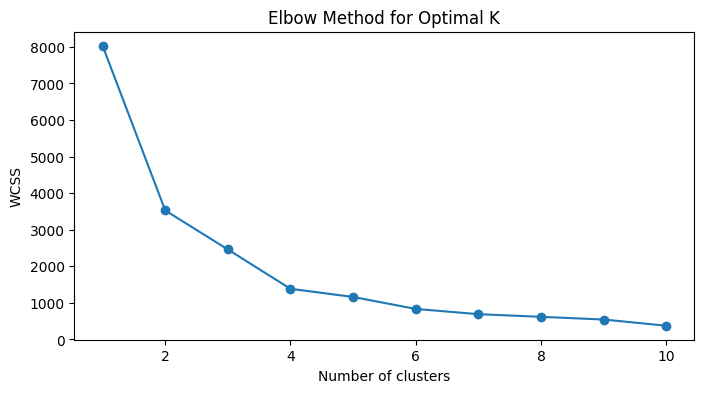

In [19]:
# Calculate Within-Cluster Sum of Squares (WCSS) for different values of K
wcss = []
for i in range(1, 11):
    kmeans_i = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans_i.fit(df_scaled[features])
    wcss.append(kmeans_i.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()
